<a href="https://www.kaggle.com/code/averma111/cafa5lightning?scriptVersionId=131271475" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture 
!pip install torchmetrics

In [2]:
%%capture 
!pip install lightning

In [3]:
## https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary#Load-train-features---precalculated-embeddings-for-the-proteins
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AUROC
from pytorch_lightning import LightningModule, Trainer ,LightningDataModule
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.profilers import SimpleProfiler
import lightning as L


import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
def get_dataframe(path):
    return pd.read_csv(path,sep='\t')

In [5]:
train_terms = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv'
train_taxonomy ='/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv'

In [6]:
get_dataframe(train_terms).head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [7]:
get_dataframe(train_taxonomy).head()

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


In [8]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['duplicate'] = df.duplicated().sum()
    return summ

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
summary('train_terms',reduce_mem_usage(get_dataframe(train_terms)))

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%
train_terms shape: (5363863, 3)


,dtypes,null,unique,min,median,max,mean,std,duplicate
EntryID,category,0,142246,NaN,NaN,NaN,NaN,NaN,0
term,category,0,31466,NaN,NaN,NaN,NaN,NaN,0
aspect,category,0,3,NaN,NaN,NaN,NaN,NaN,0


Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


<Axes: xlabel='aspect', ylabel='count'>

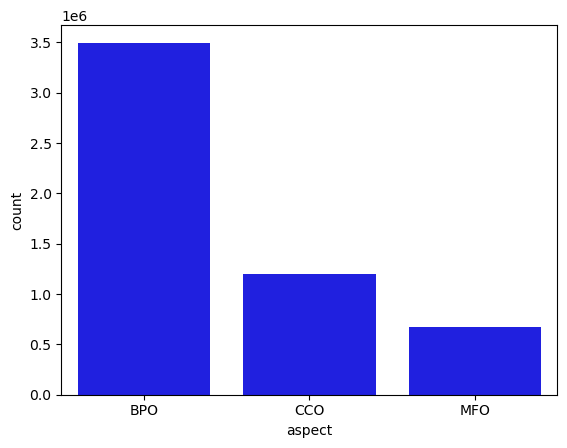

In [11]:
sns.countplot(data=reduce_mem_usage(get_dataframe(train_terms)),x='aspect',color='b')

In [12]:
train_terms=reduce_mem_usage(get_dataframe(train_terms))

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


In [13]:
class Config:
    num_of_labels = 1500
    batch_size = 512
    learning_rate = 0.001
    random_state =42
    accelerator='gpu'
    devices=1
    precision=16
    max_epochs=10
    mode="min"
    patience=10


config = Config()

In [14]:
class Preprocessing():
    
    def get_train_dataset(self):
        
        train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
        train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')
        column_num = train_embeddings.shape[1]
        train = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
        return train,train_protein_ids

    def get_label_train_terms(self,df):
        labels=df['term'].value_counts().index[:config.num_of_labels].tolist()
        train_terms_updated=df.loc[df['term'].isin(labels)]
        return labels,train_terms_updated

    def get_labels(self,train_protein_ids):
        train_size = train_protein_ids.shape[0] 
        train_labels = np.zeros((train_size ,config.num_of_labels))
        series_train_protein_ids = pd.Series(train_protein_ids)

        for i in range(config.num_of_labels):
            n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels_count[i]]
            label_related_proteins = n_train_terms['EntryID'].unique()
            train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
        return train_labels
    
    
    def show_pit_aspects(self):
        pie_df = train_terms_updated['aspect'].value_counts()
        palette_color = sns.color_palette('pastel')
        plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
        plt.show()
    

    
preprocess = Preprocessing()

train,train_protein_ids = preprocess.get_train_dataset()
labels_count,train_terms_updated=preprocess.get_label_train_terms(train_terms)
train_labels=preprocess.get_labels(train_protein_ids)
labels = pd.DataFrame(data = train_labels, columns = labels_count)

print(train.shape,train_protein_ids.shape,labels.shape)

(142246, 1024) (142246,) (142246, 1500)


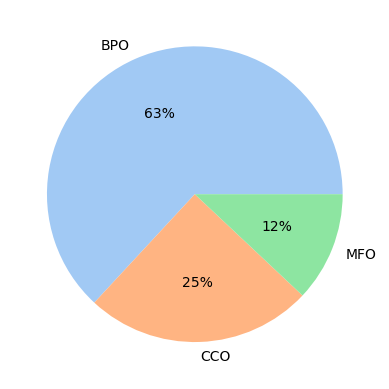

In [15]:
preprocess.show_pit_aspects()

In [16]:
class CAFA5Data(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



In [17]:
class CAFA5TestData(Dataset):
    
    def __init__(self, X_test_data):
        self.X_test_data = X_test_data
        
    def __getitem__(self, index):
        return self.X_test_data[index]
        
    def __len__ (self):
        return len(self.X_test_data)

In [18]:
class PrepareData(LightningDataModule):
    
    def __init__(self,train,labels):
        self.train = train
        self.labels = labels

    
    def setup(self, stage=None):
        
        if stage == "fit":
            
            self.X_train,self.X_val,self.y_train,self.y_val=train_test_split(self.train, self.labels,shuffle=True,random_state=config.random_state)
            self.X_data = torch.tensor(self.X_train.values,dtype=torch.float32)
            self.y_data = torch.tensor(self.y_train.values,dtype=torch.float32)
            self.X_val = torch.tensor(self.X_val.values,dtype=torch.float32)
            self.y_val = torch.tensor(self.y_val.values,dtype=torch.float32)
            
            self.train_data = CAFA5Data(self.X_data,self.y_data)
            self.val_data = CAFA5Data(self.X_val,self.y_val)
    
        if stage == "test":
            self.test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')
            self.column_num = self.test_embeddings.shape[1]
            self.X_test = pd.DataFrame(self.test_embeddings, columns = ["Column_" + str(i) for i in range(1, self.column_num+1)])
            self.X_data_test = torch.tensor(self.X_test.values,dtype=torch.float32)
            self.test_data = CAFA5TestData(self.X_data_test)
                

            
    def get_shape(self):
        return self.X_train.shape[1],self.y_train.shape[1]

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=config.batch_size,persistent_workers=True,pin_memory=True,num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=config.batch_size,persistent_workers=True,pin_memory=True,num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=config.batch_size,persistent_workers=True,pin_memory=True,num_workers=2)

In [19]:
class CAFA5Light(LightningModule):
    
    def __init__(self,input_features,output_features,learning_rate):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.learning_rate = learning_rate
        
        
        self.network = torch.nn.Sequential(
        torch.nn.Linear(self.input_features,1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024,1024),    
        torch.nn.ReLU(),
        torch.nn.Linear(1024,self.output_features)
        #torch.nn.Sigmoid()
        )
        
        
    def forward(self,inputs):
        return self.network(inputs)
    
    
    def accuracy(self,outputs, labels):
        auroc = AUROC(task="binary")
        return auroc(outputs, labels)
            
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        tensorboard_logs = {"Traininig_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
        #return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        self.accuracy(x, y)
        self.log("Validation_Loss", loss, prog_bar=True)
        #self.log("Validation_Acc", self.accuracy, prog_bar=True)
        return {"Validation_loss": loss}
        #return loss
    

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
    
   

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [20]:
data_module  = PrepareData(train,labels)
data_module.setup('fit')
model = CAFA5Light(*data_module.get_shape(),config.learning_rate)
print(model)


CAFA5Light(
  (network): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1500, bias=True)
  )
)


In [21]:
early_stopping = EarlyStopping(monitor="Validation_Loss", mode=config.mode, patience=config.patience)
logger = TensorBoardLogger("/kaggle/working/lightning_logs", name="CAFA5Logging")
profiler = SimpleProfiler()
trainer = Trainer(accelerator=config.accelerator, devices=config.devices, precision=config.precision,
                  max_epochs=config.max_epochs,callbacks=[early_stopping],logger=logger)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model,data_module.train_dataloader(),data_module.val_dataloader()) 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


In [23]:
data_module.setup('test')
predictions=trainer.predict(model,data_module.test_dataloader())

Predicting: 0it [00:00, ?it/s]

In [32]:
type(predictions)

list

In [33]:
def make_predictions(prediction_target):
    test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
    protein_list = []
    for k in list(test_protein_ids):
        protein_list += [k] * len(prediction_target)
    return protein_list

protein_list=make_predictions(predictions)      

In [34]:
def submit():
    df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
    df_submission['Protein Id'] = protein_list
    df_submission['GO Term Id'] = labels_count * predictions.shape[0]
    df_submission['Prediction'] = predictions.ravel()
    df_submission.to_csv("submission.tsv",header=False, index=False,sep='\t')
    
submit()

39438470